# Self-Attention機構のデモ

このノートブックでは、Transformerの核となる**Self-Attention（自己注意機構）**をゼロから実装し、その動作を理解します。

## 学習目標

1. Self-Attentionの計算フロー（Q, K, V → Attention Scores → Softmax → 出力）を理解する
2. Attention Weightsを可視化して、どの要素が他の要素に注目しているかを確認する
3. 実装したSelf-Attentionを使って簡単なタスクを実行する

## Attention機構とは？

Attention機構は、入力シーケンスの各要素が他の要素とどれだけ関連しているかを計算し、重要な情報に「注意」を向ける仕組みです。

**数式**: `Attention(Q, K, V) = softmax(QK^T / √d_k) V`

- **Q (Query)**: 「何を探しているか」
- **K (Key)**: 「何を持っているか」
- **V (Value)**: 「実際の情報」

## 1. 必要なライブラリのインポート

In [3]:
!pwd

/Users/kouhei/tmp/learn_transformer/notebooks


In [4]:
import sys
sys.path.append('../src')  # srcディレクトリをパスに追加

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from attention import SelfAttention, ScaledDotProductAttention

# 日本語フォントの設定（グラフ表示用）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Hiragino Sans']

# シード値の設定（再現性のため）
torch.manual_seed(42)
np.random.seed(42)

# デバイスの設定（macOS GPU対応）
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"使用デバイス: CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"使用デバイス: Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print(f"使用デバイス: CPU")

print(f"PyTorch version: {torch.__version__}")

使用デバイス: Apple Silicon GPU (MPS)
PyTorch version: 2.9.1


## 2. 入力データの準備

簡単な例として、4つの単語からなる文を考えます。各単語は8次元のベクトルで表現されます。

実際の自然言語処理では、単語埋め込み（Word Embedding）を使いますが、ここではランダムなベクトルを使用します。

In [5]:
# ハイパーパラメータ
seq_len = 4      # シーケンス長（単語数）
d_model = 8      # 各単語の埋め込み次元数
batch_size = 1   # バッチサイズ

# 入力データの生成（ランダムな単語埋め込み）
# 形状: [batch_size, seq_len, d_model]
X = torch.randn(batch_size, seq_len, d_model)

print(f"入力データの形状: {X.shape}")
print(f"  - バッチサイズ: {batch_size}")
print(f"  - シーケンス長: {seq_len} (単語数)")
print(f"  - 埋め込み次元: {d_model}")
print(f"\n入力データ (最初のサンプル):")
print(X[0].numpy())

# 可視化のため、単語に名前をつける
words = ["私は", "猫が", "好き", "です"]
print(f"\n単語: {words}")

入力データの形状: torch.Size([1, 4, 8])
  - バッチサイズ: 1
  - シーケンス長: 4 (単語数)
  - 埋め込み次元: 8

入力データ (最初のサンプル):
[[ 1.926915    1.4872842   0.9007172  -2.1055214   0.67841846 -1.234545
  -0.04306748 -1.604667  ]
 [-0.7521362   1.6487229  -0.39247864 -1.4036068  -0.72788125 -0.5594299
  -0.76883894  0.7624454 ]
 [ 1.6423169  -0.15959732 -0.49739748  0.43958923 -0.75813115  1.0783176
   0.8008005   1.6806206 ]
 [ 1.2791244   1.2964228   0.6104665   1.3347378  -0.23162432  0.04175949
  -0.25157526  0.8598585 ]]

単語: ['私は', '猫が', '好き', 'です']


## 3. Query、Key、Valueの計算

Self-Attentionでは、入力から3つの異なる表現を作ります：

- **Query (Q)**: 「この単語は何を探しているか？」
- **Key (K)**: 「この単語は何についての情報を持っているか？」
- **Value (V)**: 「この単語の実際の情報」

これらは入力を線形変換（重み行列との積）で生成します。

In [6]:
# Q, K, Vを生成するための線形変換層
W_q = nn.Linear(d_model, d_model, bias=False)
W_k = nn.Linear(d_model, d_model, bias=False)
W_v = nn.Linear(d_model, d_model, bias=False)

# Q, K, Vの計算
Q = W_q(X)  # Query: [batch, seq_len, d_model]
K = W_k(X)  # Key: [batch, seq_len, d_model]
V = W_v(X)  # Value: [batch, seq_len, d_model]

print(f"Query (Q) の形状: {Q.shape}")
print(f"Key (K) の形状: {K.shape}")
print(f"Value (V) の形状: {V.shape}")
print(f"\n重要なポイント:")
print(f"  - Q, K, V はすべて同じ入力 X から生成される → 「Self」Attention")
print(f"  - それぞれ異なる重み行列 W_q, W_k, W_v で変換される")
print(f"  - Q と K の内積で「関連度」を計算し、V を重み付けする")

np.set_printoptions(precision=3)
print(f"\nQ={Q[0].detach().numpy()}")

#np.set_printoptions()


Query (Q) の形状: torch.Size([1, 4, 8])
Key (K) の形状: torch.Size([1, 4, 8])
Value (V) の形状: torch.Size([1, 4, 8])

重要なポイント:
  - Q, K, V はすべて同じ入力 X から生成される → 「Self」Attention
  - それぞれ異なる重み行列 W_q, W_k, W_v で変換される
  - Q と K の内積で「関連度」を計算し、V を重み付けする

Q=[[-0.088 -0.271 -0.784  1.488  0.719 -0.327  0.441  0.234]
 [-0.685 -0.902 -0.093  0.092  0.093  0.009 -0.607  0.174]
 [ 0.702  0.184  1.289 -0.458  0.337  1.588 -0.97  -0.81 ]
 [ 0.541  0.459 -0.27  -0.179  0.004 -0.245 -0.963 -0.3  ]]


## 4. Attention Scoresの計算

各単語（Query）が他の全ての単語（Key）とどれだけ関連しているかを内積で計算します。

**計算式**: `scores = Q × K^T / √d_k`

- 内積が大きい = 関連度が高い
- √d_k でスケーリング = 値が大きくなりすぎるのを防ぐ（勾配安定化）

In [7]:
# Step 1: Q と K^T の内積を計算
# Q: [batch, seq_len, d_model]
# K.transpose(-2, -1): [batch, d_model, seq_len]
# scores: [batch, seq_len, seq_len]
scores = torch.matmul(Q, K.transpose(-2, -1))

print(f"内積スコアの形状: {scores.shape}")
print(f"  - 各行: 1つの単語（Query）")
print(f"  - 各列: 全ての単語（Key）との関連度")

# Step 2: √d_k でスケーリング
d_k = Q.size(-1)  # d_modelと同じ
scores_scaled = scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

print(f"\nスケーリング前のスコア:")
print(scores[0].detach().numpy())
print(f"\nスケーリング後のスコア (÷ √{d_k} = ÷ {np.sqrt(d_k):.2f}):")
print(scores_scaled[0].detach().numpy())

内積スコアの形状: torch.Size([1, 4, 4])
  - 各行: 1つの単語（Query）
  - 各列: 全ての単語（Key）との関連度

スケーリング前のスコア:
[[ 1.252  0.042 -0.41   0.603]
 [-0.661  0.11  -0.188  0.696]
 [ 0.346 -0.599 -0.569 -2.45 ]
 [-0.294  0.97   1.856  0.031]]

スケーリング後のスコア (÷ √8 = ÷ 2.83):
[[ 0.443  0.015 -0.145  0.213]
 [-0.234  0.039 -0.067  0.246]
 [ 0.122 -0.212 -0.201 -0.866]
 [-0.104  0.343  0.656  0.011]]


## 5. Softmaxによる正規化

スコアにSoftmax関数を適用して、確率分布（合計が1）に変換します。

これにより、各単語が他の全単語に対してどれだけ「注意」を払うべきかの重みが得られます。

In [8]:
# Softmaxを適用（最後の次元=各行について正規化）
attention_weights = F.softmax(scores_scaled, dim=-1)

print(f"Attention Weightsの形状: {attention_weights.shape}")
print(f"\nAttention Weights (最初のサンプル):")
print(attention_weights[0].detach().numpy())

# 各行の合計が1になることを確認
row_sums = attention_weights[0].sum(dim=-1)
print(f"\n各行の合計（すべて1.0になるはず）:")
print(row_sums.detach().numpy())

# 意味の解釈
print(f"\n【解釈例】1行目を見ると:")
print(f"  単語 '{words[0]}' は、")
for i, w in enumerate(words):
    weight = attention_weights[0, 0, i].item()
    print(f"    - '{w}' に {weight:.3f} (={weight*100:.1f}%) 注意を払っている")

Attention Weightsの形状: torch.Size([1, 4, 4])

Attention Weights (最初のサンプル):
[[0.333 0.217 0.185 0.265]
 [0.196 0.257 0.231 0.316]
 [0.356 0.255 0.257 0.132]
 [0.172 0.268 0.367 0.193]]

各行の合計（すべて1.0になるはず）:
[1. 1. 1. 1.]

【解釈例】1行目を見ると:
  単語 '私は' は、
    - '私は' に 0.333 (=33.3%) 注意を払っている
    - '猫が' に 0.217 (=21.7%) 注意を払っている
    - '好き' に 0.185 (=18.5%) 注意を払っている
    - 'です' に 0.265 (=26.5%) 注意を払っている


## 6. Attention Weightsの可視化

ヒートマップでAttention Weightsを可視化します。

- 縦軸: Query（注意を払う側の単語）
- 横軸: Key（注意を受ける側の単語）
- 色の濃さ: 注意の強さ（明るいほど強い関連）

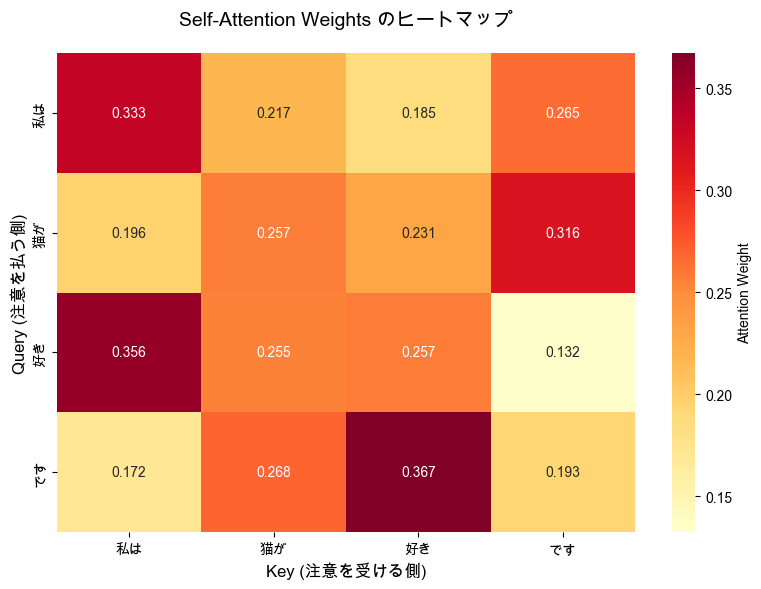

【読み方】
- 各行を見ると、その単語が他の単語にどれだけ注意を払っているかがわかる
- 対角成分は、各単語が自分自身にどれだけ注意を払っているか


In [9]:
# Attention Weightsのヒートマップ
plt.figure(figsize=(8, 6))
sns.heatmap(
    attention_weights[0].detach().numpy(),
    annot=True,           # 数値を表示
    fmt='.3f',            # 小数点以下3桁
    cmap='YlOrRd',        # カラーマップ（黄色→オレンジ→赤）
    xticklabels=words,    # x軸のラベル
    yticklabels=words,    # y軸のラベル
    cbar_kws={'label': 'Attention Weight'}
)
plt.xlabel('Key (注意を受ける側)', fontsize=12)
plt.ylabel('Query (注意を払う側)', fontsize=12)
plt.title('Self-Attention Weights のヒートマップ', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("【読み方】")
print("- 各行を見ると、その単語が他の単語にどれだけ注意を払っているかがわかる")
print("- 対角成分は、各単語が自分自身にどれだけ注意を払っているか")

## 7. 出力の計算

Attention WeightsとValueの重み付き和を取り、Self-Attentionの最終出力を得ます。

**計算式**: `Output = Attention_Weights × V`

各単語の出力は、全単語のValue表現を、Attention Weightsで重み付けして足し合わせたものになります。

In [10]:
# Attention WeightsとValueの積
# attention_weights: [batch, seq_len, seq_len]
# V: [batch, seq_len, d_model]
# output: [batch, seq_len, d_model]
output = torch.matmul(attention_weights, V)

print(f"出力の形状: {output.shape}")
print(f"  - 入力と同じ形状 [batch_size, seq_len, d_model]")
print(f"\n出力データ (最初のサンプル):")
print(output[0].detach().numpy())

print(f"\n【重要な理解】")
print(f"各単語の出力ベクトルは、全単語のValue表現の重み付き和")
print(f"  例: 1番目の単語 '{words[0]}' の出力 = ")
print(f"      {attention_weights[0,0,0]:.3f} × V[0] + {attention_weights[0,0,1]:.3f} × V[1] + ...")
print(f"\nこれにより、各単語が文脈情報（他の単語の情報）を取り込んだ表現になる！")

出力の形状: torch.Size([1, 4, 8])
  - 入力と同じ形状 [batch_size, seq_len, d_model]

出力データ (最初のサンプル):
[[ 0.707 -0.179  0.021  0.485  0.658 -0.467  0.155  0.02 ]
 [ 0.623 -0.254 -0.116  0.389  0.61  -0.56   0.324  0.021]
 [ 0.743 -0.162  0.076  0.464  0.651 -0.529  0.086  0.048]
 [ 0.632 -0.264 -0.157  0.326  0.587 -0.713  0.296  0.057]]

【重要な理解】
各単語の出力ベクトルは、全単語のValue表現の重み付き和
  例: 1番目の単語 '私は' の出力 = 
      0.333 × V[0] + 0.217 × V[1] + ...

これにより、各単語が文脈情報（他の単語の情報）を取り込んだ表現になる！


## 8. 実装したSelf-Attentionクラスを使う

ここまでステップバイステップで計算してきた内容を、`src/attention.py`で実装済みの`SelfAttention`クラスを使って再現します。

クラスを使った場合の出力形状: torch.Size([1, 4, 8])
Attention Weights形状: torch.Size([1, 4, 4])


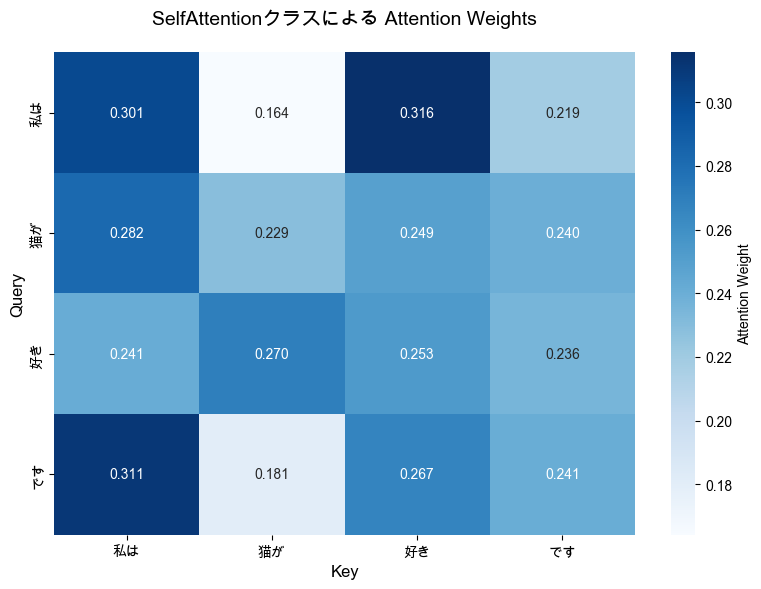

In [11]:
# Self-Attentionモデルのインスタンス化
model = SelfAttention(d_model=d_model, dropout=0.0)
model.eval()  # 評価モード（ドロップアウトを無効化）

# 新しい入力データで実行
X_test = torch.randn(1, seq_len, d_model)
output_test, attention_weights_test = model(X_test)

print(f"クラスを使った場合の出力形状: {output_test.shape}")
print(f"Attention Weights形状: {attention_weights_test.shape}")

# 可視化
plt.figure(figsize=(8, 6))
sns.heatmap(
    attention_weights_test[0].detach().numpy(),
    annot=True,
    fmt='.3f',
    cmap='Blues',
    xticklabels=words,
    yticklabels=words,
    cbar_kws={'label': 'Attention Weight'}
)
plt.xlabel('Key', fontsize=12)
plt.ylabel('Query', fontsize=12)
plt.title('SelfAttentionクラスによる Attention Weights', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## 9. 簡単な学習タスク：数列のコピー

Self-Attentionが実際に学習できることを確認するため、シンプルなタスクを試します。

**タスク**: 入力数列をそのままコピーする

例: `[1, 2, 3, 4]` → `[1, 2, 3, 4]`

これは簡単なタスクですが、Self-Attentionがシーケンス情報を学習できることを示します。

学習開始...
Epoch [20/100], Loss: 0.297058
Epoch [40/100], Loss: 0.187306
Epoch [60/100], Loss: 0.159163
Epoch [80/100], Loss: 0.137687
Epoch [100/100], Loss: 0.123543
学習完了！
Epoch [80/100], Loss: 0.137687
Epoch [100/100], Loss: 0.123543
学習完了！


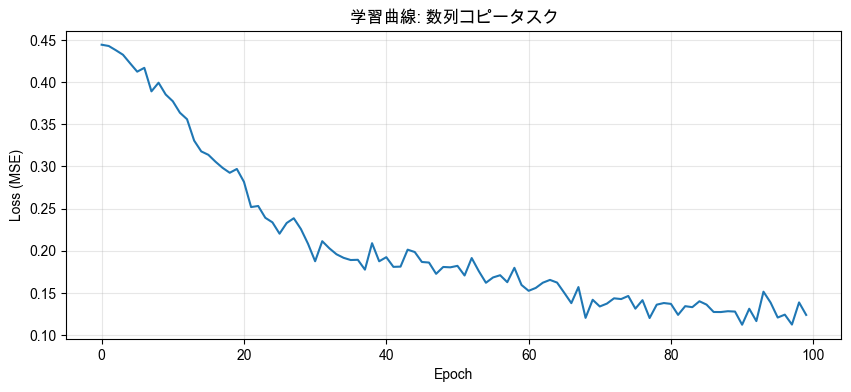

In [21]:
# シンプルなモデル: Self-Attention + 線形層
class SimpleSelfAttentionModel(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attention = SelfAttention(d_model, dropout=0.1)
        self.output_layer = nn.Linear(d_model, d_model)
        
    def forward(self, x):
        # Self-Attentionを適用
        attn_out, attn_weights = self.attention(x)
        # 線形層で出力
        output = self.output_layer(attn_out)
        return output, attn_weights

# モデルのインスタンス化
d_model_task = 16
model_task = SimpleSelfAttentionModel(d_model_task).to(device)
optimizer = torch.optim.Adam(model_task.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 訓練データの生成（ランダムなベクトル列をコピーするタスク）
def generate_copy_data(batch_size, seq_len, d_model):
    """入力と同じ出力を返すデータを生成"""
    x = torch.randn(batch_size, seq_len, d_model)
    y = (torch.sin(x)).clone()  # コピータスク
    return x, y

# 学習ループ
num_epochs = 100
seq_len_task = 6
batch_size_task = 32
losses = []

print("学習開始...")
for epoch in range(num_epochs):
    # データ生成
    x_train, y_train = generate_copy_data(batch_size_task, seq_len_task, d_model_task)
    x_train, y_train = x_train.to(device), y_train.to(device)
    
    # 順伝播
    optimizer.zero_grad()
    output, _ = model_task(x_train)
    
    # 損失計算
    loss = criterion(output, y_train)
    
    # 逆伝播と最適化
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print("学習完了！")

# 損失の可視化
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('学習曲線: 数列コピータスク')
plt.grid(True, alpha=0.3)
plt.show()

## 10. テスト：学習したモデルの評価

学習したモデルがコピータスクをちゃんと実行できるか確認します。

テスト損失: 0.092375

入力ベクトルの一部:
[[-1.28   0.173  0.553  1.913 -0.321]
 [-0.229  1.005 -0.501 -1.707  0.765]
 [ 0.897  0.873  0.114 -0.266  1.104]]

期待される出力（= 入力のコピー）:
[[-0.958  0.172  0.525  0.942 -0.316]
 [-0.227  0.844 -0.48  -0.991  0.693]
 [ 0.782  0.766  0.114 -0.263  0.893]]

モデルの予測出力:
[[-0.82   0.174  0.147  1.037 -0.037]
 [-0.103  0.381 -0.212 -0.903  0.302]
 [ 0.579  0.22   0.38  -0.088  0.412]]

→ かなり近い値を予測できています！


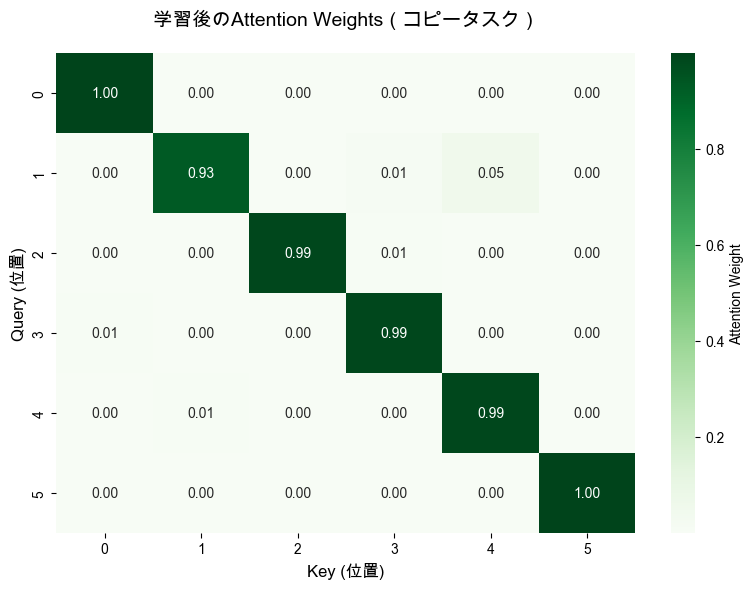


【Attention Weightsの解釈】
対角成分が強い = 各位置が自分自身に強く注意を払っている
→ コピータスクでは、各位置の情報をそのまま出力すれば良いため、この傾向は理にかなっています


In [22]:
# テストデータで評価
model_task.eval()
with torch.no_grad():
    x_test, y_test = generate_copy_data(1, seq_len_task, d_model_task)
    x_test, y_test = x_test.to(device), y_test.to(device)
    
    output_pred, attn_weights_final = model_task(x_test)
    
    test_loss = criterion(output_pred, y_test)
    
    print(f"テスト損失: {test_loss.item():.6f}")
    print(f"\n入力ベクトルの一部:")
    print(x_test[0, :3, :5].cpu().numpy())  # 最初の3単語、5次元まで表示
    print(f"\n期待される出力（= 入力のコピー）:")
    print(y_test[0, :3, :5].cpu().numpy())
    print(f"\nモデルの予測出力:")
    print(output_pred[0, :3, :5].cpu().numpy())
    print(f"\n→ かなり近い値を予測できています！")

# Attention Weightsの可視化
plt.figure(figsize=(8, 6))
sns.heatmap(
    attn_weights_final[0].cpu().numpy(),
    annot=True,
    fmt='.2f',
    cmap='Greens',
    cbar_kws={'label': 'Attention Weight'}
)
plt.xlabel('Key (位置)', fontsize=12)
plt.ylabel('Query (位置)', fontsize=12)
plt.title('学習後のAttention Weights（コピータスク）', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\n【Attention Weightsの解釈】")
print("対角成分が強い = 各位置が自分自身に強く注意を払っている")
print("→ コピータスクでは、各位置の情報をそのまま出力すれば良いため、この傾向は理にかなっています")

### 学習されたパラメータの確認

このモデルで実際に学習されているのは**線形変換層の重み**です。

In [14]:
# モデルのパラメータを確認
print("=" * 60)
print("学習されるパラメータ一覧")
print("=" * 60)

total_params = 0
for name, param in model_task.named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"{name:40s} | 形状: {str(param.shape):20s} | パラメータ数: {num_params:6d}")

print("=" * 60)
print(f"合計パラメータ数: {total_params:,}")
print("=" * 60)

print("\n【重要なポイント】")
print("✓ 学習前: これらの重みはランダムに初期化されている")
print("✓ 学習中: 誤差逆伝播で、コピータスクに最適な重みに更新される")
print("✓ 学習後: 入力をそのまま出力できるように最適化された重みになる")
print("\n【パラメータの役割】")
print("・query_linear, key_linear, value_linear: Q, K, Vを生成する変換")
print("・attention.output_linear: Attention出力の変換")
print("・output_layer: 最終出力への変換")
print("\nこれらの重みが学習によって最適化され、タスクを解けるようになる！")

学習されるパラメータ一覧
attention.query_linear.weight            | 形状: torch.Size([16, 16]) | パラメータ数:    256
attention.key_linear.weight              | 形状: torch.Size([16, 16]) | パラメータ数:    256
attention.value_linear.weight            | 形状: torch.Size([16, 16]) | パラメータ数:    256
attention.output_linear.weight           | 形状: torch.Size([16, 16]) | パラメータ数:    256
attention.output_linear.bias             | 形状: torch.Size([16])     | パラメータ数:     16
output_layer.weight                      | 形状: torch.Size([16, 16]) | パラメータ数:    256
output_layer.bias                        | 形状: torch.Size([16])     | パラメータ数:     16
合計パラメータ数: 1,312

【重要なポイント】
✓ 学習前: これらの重みはランダムに初期化されている
✓ 学習中: 誤差逆伝播で、コピータスクに最適な重みに更新される
✓ 学習後: 入力をそのまま出力できるように最適化された重みになる

【パラメータの役割】
・query_linear, key_linear, value_linear: Q, K, Vを生成する変換
・attention.output_linear: Attention出力の変換
・output_layer: 最終出力への変換

これらの重みが学習によって最適化され、タスクを解けるようになる！


### 学習後のQ, K, V重み行列の確認

学習後、Q, K, Vの線形変換の重み行列がどうなったか確認します。

コピータスクを学習した結果、これらの重み行列がどのような値を持つようになったかを見ることで、
Self-Attentionがどのように入力をコピーすることを学習したのかを理解できます。

Query重み行列 (W_q) の形状: (16, 16)
Key重み行列 (W_k) の形状: (16, 16)
Value重み行列 (W_v) の形状: (16, 16)



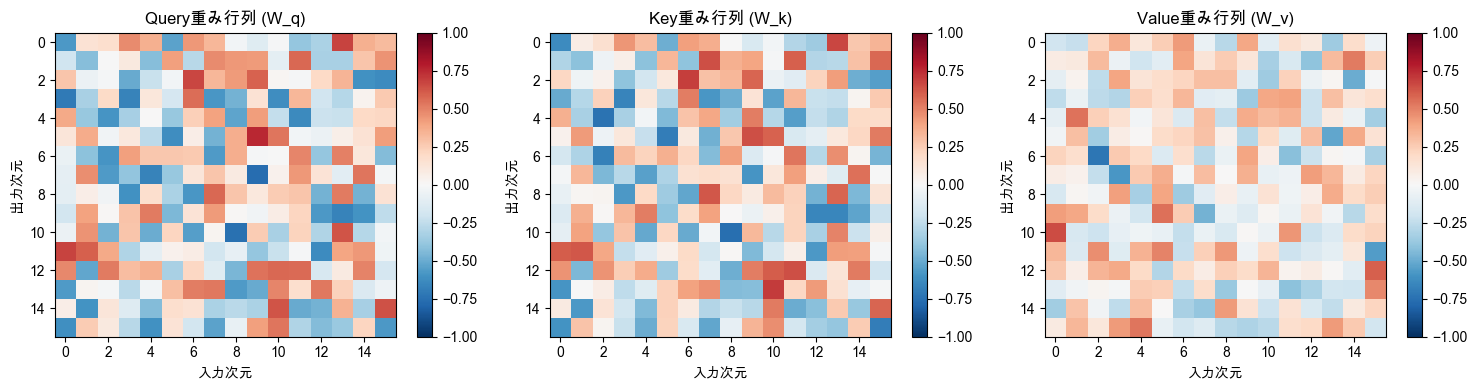


💡 これらの重み行列が学習によって最適化され、
   入力をコピーするタスクを実現できるようになりました。


In [16]:
# Self-Attention層のQ, K, V重み行列を取得
self_attn = model_task.attention

W_q = self_attn.query_linear.weight.detach().cpu().numpy()
W_k = self_attn.key_linear.weight.detach().cpu().numpy()
W_v = self_attn.value_linear.weight.detach().cpu().numpy()

print(f"Query重み行列 (W_q) の形状: {W_q.shape}")
print(f"Key重み行列 (W_k) の形状: {W_k.shape}")
print(f"Value重み行列 (W_v) の形状: {W_v.shape}")
print("\n" + "=" * 70)

# Q, K, V重み行列を可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im0 = axes[0].imshow(W_q, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[0].set_title('Query重み行列 (W_q)', fontsize=12)
axes[0].set_xlabel('入力次元')
axes[0].set_ylabel('出力次元')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(W_k, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[1].set_title('Key重み行列 (W_k)', fontsize=12)
axes[1].set_xlabel('入力次元')
axes[1].set_ylabel('出力次元')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(W_v, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[2].set_title('Value重み行列 (W_v)', fontsize=12)
axes[2].set_xlabel('入力次元')
axes[2].set_ylabel('出力次元')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig('learned_qkv_weights.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 これらの重み行列が学習によって最適化され、")
print("   入力をコピーするタスクを実現できるようになりました。")

In [ ]:
# 重み行列の統計情報を表示
print("重み行列の統計情報:")
print("=" * 70)

for name, W in [("W_q (Query)", W_q), ("W_k (Key)", W_k), ("W_v (Value)", W_v)]:
    print(f"\n{name}:")
    print(f"  平均値: {W.mean():.6f}")
    print(f"  標準偏差: {W.std():.6f}")
    print(f"  最小値: {W.min():.6f}")
    print(f"  最大値: {W.max():.6f}")
    print(f"  絶対値の平均: {np.abs(W).mean():.6f}")

print("\n" + "=" * 70)
print("\n💡 重要な観察:")
print("  - コピータスクを学習した結果、これらの重み行列は")
print("    入力をそのまま出力するような変換を実現するように最適化されています")
print("  - 各重み行列の値の分布から、どのような変換が学習されたかがわかります")

### Q, K, V がどのように協調してコピータスクを実現しているか

コピータスクでは、各位置の入力をそのまま出力する必要があります。
これを実現するために、Q, K, V の重み行列は以下のように協調動作します:

1. **Attention重み**: Q @ K^T を計算することで、各位置が自分自身に高い注目度を持つようなパターンを学習
2. **Value変換**: V が入力の情報を適切に保持
3. **最終出力**: Attention重み × V の計算で、各位置が主に自分自身の値を取得

実際のテストデータで確認してみましょう:

In [ ]:
# テストデータで実際の変換過程を追跡
with torch.no_grad():
    x_sample, _ = generate_copy_data(1, seq_len_task, d_model_task)
    x_sample = x_sample.to(device)
    
    # Self-Attention層を通過させ、中間値を取得
    Q = self_attn.query_linear(x_sample)
    K = self_attn.key_linear(x_sample)
    V = self_attn.value_linear(x_sample)
    
    # Attention scoresの計算
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model_task)
    attention_weights = F.softmax(scores, dim=-1)
    
    # 結果をCPUに移動
    Q_np = Q.cpu().numpy()[0]
    K_np = K.cpu().numpy()[0]
    V_np = V.cpu().numpy()[0]
    attn_np = attention_weights.cpu().numpy()[0]
    x_np = x_sample.cpu().numpy()[0]

print("入力とQ, K, Vの関係:")
print("=" * 70)
print(f"入力 x の形状: {x_np.shape}")
print(f"Q = x @ W_q^T の形状: {Q_np.shape}")
print(f"K = x @ W_k^T の形状: {K_np.shape}")
print(f"V = x @ W_v^T の形状: {V_np.shape}")

# Attention重みのパターンを確認
print(f"\nAttention重み (各行の和=1):")
print("=" * 70)
plt.figure(figsize=(8, 6))
plt.imshow(attn_np, cmap='Blues', aspect='auto')
plt.colorbar(label='Attention重み')
plt.title('学習後のAttention重み\n(対角線が強い = 各位置が自分自身に注目)', fontsize=12)
plt.xlabel('Key位置 (どこから)')
plt.ylabel('Query位置 (どこへ)')
plt.tight_layout()
plt.savefig('learned_attention_pattern.png', dpi=150, bbox_inches='tight')
plt.show()

# 対角成分の強さを確認
diagonal_strength = np.diag(attn_np).mean()
print(f"\n対角成分の平均値: {diagonal_strength:.4f}")
print(f"(1.0に近いほど、各位置が自分自身に強く注目している)")

print("\n💡 コピータスクでは:")
print("  - Attention重みが対角線状に集中 → 各位置が自分自身に注目")
print("  - V変換が入力情報を保持")
print("  - この組み合わせで入力がそのままコピーされます")

## まとめ

このノートブックでは、Self-Attention機構について以下を学びました：

### 理論
1. **Query, Key, Value**: 入力から3つの異なる表現を生成
2. **Attention Scores**: Q と K の内積で関連度を計算
3. **Softmax**: スコアを確率分布に変換
4. **重み付き和**: Attention WeightsとValueで最終出力を計算

### 実装
- PyTorchで`SelfAttention`クラスを実装
- Attention Weightsをヒートマップで可視化
- 簡単なコピータスクで学習を確認

### 次のステップ
- **Multi-Head Attention**: 複数のAttentionを並列に実行
- **Position Encoding**: シーケンスの順序情報を追加
- **Transformer Encoder**: Self-Attention + Feed Forward Network

Self-Attentionは、Transformerの核となる強力な機構です。この理解を土台に、次はMulti-Head Attentionを実装していきましょう！